# SWA145 flights: LAX to LIH (LA TO KAUAI)

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_latimes as lat
import datetime as dt
import requests
import glob
from shapely.geometry import Point, LineString, MultiLineString

/Users/mhustiles/.local/share/virtualenvs/notebooks-xu8v5Vvv/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Grab all the csv files downloaded from FlightRadar24

In [4]:
### https://www.flightradar24.com/data/flights/wn145

path = "data/raw/lax-lih/"
all_files = glob.glob(path + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

src = pd.concat(li, axis=0, ignore_index=True)

In [5]:
src.sort_values("UTC", ascending=False).head()

,Timestamp,UTC,Callsign,Position,Altitude,Speed,Direction
13569,1628802807,2021-08-12T21:13:27Z,SWA145,"21.977369,-159.347885",0,13,225
13568,1628802802,2021-08-12T21:13:22Z,SWA145,"21.977577,-159.347672",0,12,225
13567,1628802797,2021-08-12T21:13:17Z,SWA145,"21.977783,-159.347458",0,11,227
13566,1628802792,2021-08-12T21:13:12Z,SWA145,"21.977921,-159.347244",0,9,253
13565,1628802787,2021-08-12T21:13:07Z,SWA145,"21.977966,-159.347015",0,10,286


### Clean up column names

In [6]:
src.columns = src.columns.str.lower()

### Convert UTC dates to Pacific time

In [7]:
src["datetime_utc"] = pd.to_datetime(src.utc).dt.tz_convert("US/Pacific")

In [8]:
src["date_pacfic"] = src["datetime_utc"].dt.date.astype(str)

In [9]:
src["time_pacfic"] = src["datetime_utc"].dt.time.astype(str)

### Make a unique ID for each flight

In [10]:
src["id"] = (
    src["callsign"]
    + "_"
    + src["date_pacfic"].astype(str).str.replace("-", "", regex=False)
)

---

### Summary stats on our dataframe

In [11]:
df = src.copy()

### Group by flight and mean speed

In [12]:
mean_speed_flight = (
    df[df["speed"] > 150].groupby(["id"]).agg({"speed": "mean"}).reset_index()
)

### 'Slowest' flights? 

In [13]:
mean_speed_flight.sort_values("speed", ascending="false").head()

,id,speed
21,SWA145_20210721,289.767857
38,SWA145_20210808,314.137809
40,SWA145_20210810,315.344371
37,SWA145_20210807,318.715847
30,SWA145_20210731,320.636015


### 'Fastest' flights? 

In [14]:
mean_speed_flight.sort_values("speed", ascending="false").tail()

,id,speed
17,SWA145_20210715,354.560311
11,SWA145_20210708,356.572917
34,SWA145_20210804,359.919355
10,SWA145_20210707,362.586873
42,SWA145_20210812,374.477690


### Group by flight and mean altitude

In [15]:
mean_altitude_flight = (
    df[df["altitude"] > 0].groupby(["id"]).agg({"altitude": "mean"}).reset_index()
)

### 'Highest' flights?

In [16]:
mean_altitude_flight.sort_values("altitude", ascending="false").tail()

,id,altitude
26,SWA145_20210727,17607.947020
34,SWA145_20210804,17925.307692
2,SWA145_20210629,18308.392226
10,SWA145_20210707,18452.537594
42,SWA145_20210812,19740.982587


### 'Lowest' flights?

In [17]:
mean_altitude_flight.sort_values("altitude", ascending="false").head()

,id,altitude
21,SWA145_20210721,9710.021097
37,SWA145_20210807,13558.444149
1,SWA145_20210628,14407.343234
40,SWA145_20210810,14558.359375
36,SWA145_20210806,14583.527697


### Split the lat/lon and make a geodataframe

In [18]:
df[["latitude", "longitude"]] = df["position"].str.split(",", expand=True)

### Drop what we don't need

In [19]:
df.drop(
    ["utc", "position", "timestamp", "datetime_utc", "callsign"],
    axis=1,
    inplace=True,
)

In [20]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

### Simple plot

<AxesSubplot:>

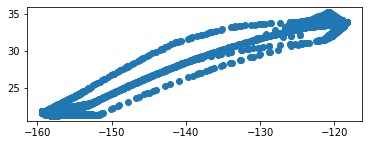

In [21]:
gdf.plot()

In [22]:
gdf.head()

,altitude,speed,direction,date_pacfic,time_pacfic,id,latitude,longitude,geometry
0,0,0,272,2021-08-05,08:16:54,SWA145_20210805,33.946655,-118.400902,POINT (-118.40090 33.94665)
1,0,3,244,2021-08-05,08:32:55,SWA145_20210805,33.946579,-118.400642,POINT (-118.40064 33.94658)
2,0,2,196,2021-08-05,08:33:11,SWA145_20210805,33.946655,-118.400429,POINT (-118.40043 33.94665)
3,0,3,174,2021-08-05,08:33:28,SWA145_20210805,33.946857,-118.400375,POINT (-118.40037 33.94686)
4,0,2,281,2021-08-05,08:33:56,SWA145_20210805,33.947124,-118.400444,POINT (-118.40044 33.94712)


### We need lines to plot the flights

In [23]:
gdf_lines = gpd.GeoDataFrame(
    gdf.groupby(["id", "date_pacfic"])["geometry"]
    .apply(lambda x: LineString(x.tolist()))
    .reset_index()
)

<AxesSubplot:>

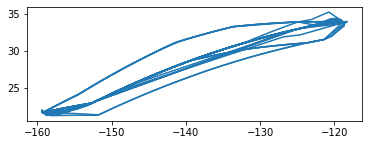

In [24]:
gdf_lines.plot()

---

### Get schedule from FlightRadar24 page

In [25]:
sched = pd.read_csv("data/raw/recent_flights_lax_lih.csv", parse_dates=["date"])

In [26]:
sched["begin"] = sched["begin"].str.replace("(LAX)", "", regex=False)
sched["end"] = sched["end"].str.replace("(LIH)", "", regex=False)

In [27]:
sched[["aircraft", "callsign"]] = sched["plane"].str.split("(", expand=True)

In [28]:
sched["callsign"] = sched["callsign"].str.replace(")", "", regex=False)

In [29]:
sched["land_actual"] = sched["land_actual"].str.replace("Landed ", "", regex=False)

In [30]:
sched.drop(["Unnamed: 8", "Unnamed: 10", "plane"], axis=1, inplace=True)

In [31]:
sched["flight_time"] = pd.to_datetime(sched["flight_time"], format="%H:%M").dt.time

In [32]:
sched.head()

,date,begin,end,flight_time,leave_sched,leave_actual,land_sched,land_actual,aircraft,callsign
0,2021-08-06,Los Angeles,Lihue,05:29:00,8:30 AM,9:18 AM,11:20 AM,11:48 AM,B38M,N8718Q
1,2021-08-05,Los Angeles,Lihue,05:23:00,8:30 AM,8:40 AM,11:20 AM,11:02 AM,B738,N8309C
2,2021-08-04,Los Angeles,Lihue,05:31:00,8:30 AM,8:40 AM,11:20 AM,11:11 AM,B738,N8309C
3,2021-08-03,Los Angeles,Lihue,05:24:00,8:30 AM,8:40 AM,11:20 AM,11:04 AM,B38M,N8713M
4,2021-08-02,Los Angeles,Lihue,05:25:00,8:30 AM,9:04 AM,11:20 AM,11:29 AM,B38M,N8713M


---

### Exports

In [33]:
gdf.to_file("data/processed/lax_lih_flights_points.geojson", driver="GeoJSON")

In [34]:
gdf_lines.to_file("data/processed/lax_lih_flights_lines.geojson", driver="GeoJSON")

In [35]:
import fiona

fiona.supported_drivers["KML"] = "rw"

In [36]:
gdf.to_file("data/processed/lax_lih_flights_points.kml", driver="KML")
gdf_lines.to_file("data/processed/lax_lih_flights_lines.kml", driver="KML")

### Our flight

In [37]:
gdf[gdf["date_pacfic"] == "2021-08-10"].to_file(
    "data/processed/lax_lih_flights_points_aug10.kml", driver="KML"
)

In [38]:
gdf_lines[gdf_lines["date_pacfic"] == "2021-08-10"].to_file(
    "data/processed/lax_lih_flights_lines_aug10.kml", driver="KML"
)